In [29]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt 



from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


init_engine()

In [30]:
learning_rate = 0.2
training_epochs = 100
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4
n_classes = 3
n_hidden = 3 # 1st layer number of features


### Sizing the Hidden Layer(s)

Sizing hidden layers can be a challenge.  The best way to figure this out is to do it
empirically.  However, we may need a "rule of thumb" to start.  Here is a good rule of thumb:

First Hidden Layer:
```
n_hidden_1 = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
```

Second Hidden Layer:  (if needed)
```
n_hidden_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
```

In this case, we have a **VERY** simple dataset.  We may not need two hidden layers. Let's see what we have.


In [55]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))



Hidden layer 1 (Guess) : 2.50219710195
Hidden layer 2 (Guess) : 2.683281573


## Result

Each hidden layer should around 2-3 input neurons.

np.sqrt(np.sqrt((n_classes+2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2)))
#and in the second hidden layer, the optimal number of hidden nodes is: m*sqrt[N/(m+2)],
n_classes * np.sqrt(n_input / (n_classes + 2.))


In [31]:
iris_training = spark.read.csv("../data/iris/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [32]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



In [33]:
assembler =  VectorAssembler(inputCols=['c1','c2','c3','c4'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(iris_training)
iris_data_training = pipelineTraining.transform(iris_training)
pipelineTest = pipeline.fit(iris_test)
iris_data_test = pipelineTraining.transform(iris_test)

In [34]:
iris_data_training.select('features', 'label').show(10, False)

+----------------------------------------------------------------------------+-----+
|features                                                                    |label|
+----------------------------------------------------------------------------+-----+
|[7.3683612551017434,6.554983394668502,3.07337626655598,2.813157930275381]   |3.0  |
|[5.7565322305482365,5.384450645620555,1.8110967285062027,1.2787081501251731]|2.0  |
|[5.641401585937273,5.8526637452397345,2.469677357053913,2.1738038552127943] |3.0  |
|[5.641401585937273,7.257303044097271,0.8232257856846377,0.12787081501251732]|1.0  |
|[6.56244674282499,8.896048892764396,0.9329892237759226,0.38361244503755193] |1.0  |
|[5.065748362882449,7.491409593906861,0.7134623475933526,0.25574163002503464]|1.0  |
|[6.2170548089920965,7.959622693526039,0.8232257856846377,0.5114832600500693]|1.0  |
|[7.944014478156568,7.257303044097271,2.798967671327768,2.941028745287898]   |3.0  |
|[7.713753188934637,7.257303044097271,2.4147956380082705,1.790191

In [35]:

bigDLModel = Sequential().add(Linear(n_input, n_hidden)).add(Linear(n_hidden, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(16).setTrain
model = dlClassifier.fit(iris_data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier

initial model training finished.


In [36]:
from pyspark.sql import DataFrame, SQLContext
predictionDF = DataFrame(model.transform(iris_data_test), SQLContext(sc))
predictionDF

DataFrame[c1: double, c2: double, c3: double, c4: double, label: double, assembled: vector, features: vector, prediction: double]

In [37]:
predictionDF.show()

+---+---+---+---+-----+-----------------+--------------------+----------+
| c1| c2| c3| c4|label|        assembled|            features|prediction|
+---+---+---+---+-----+-----------------+--------------------+----------+
|5.9|3.0|4.2|1.5|  2.0|[5.9,3.0,4.2,1.5]|[6.79270803204692...|       3.0|
|6.9|3.1|5.4|2.1|  3.0|[6.9,3.1,5.4,2.1]|[7.94401447815656...|       3.0|
|5.1|3.3|1.7|0.5|  1.0|[5.1,3.3,1.7,0.5]|[5.87166287515920...|       1.0|
|6.0|3.4|4.5|1.6|  2.0|[6.0,3.4,4.5,1.6]|[6.90783867665788...|       2.0|
|5.5|2.5|4.0|1.3|  2.0|[5.5,2.5,4.0,1.3]|[6.33218545360306...|       3.0|
|6.2|2.9|4.3|1.3|  2.0|[6.2,2.9,4.3,1.3]|[7.13809996587981...|       3.0|
|5.5|4.2|1.4|0.2|  1.0|[5.5,4.2,1.4,0.2]|[6.33218545360306...|       1.0|
|6.3|2.8|5.1|1.5|  3.0|[6.3,2.8,5.1,1.5]|[7.25323061049077...|       3.0|
|5.6|3.0|4.1|1.3|  2.0|[5.6,3.0,4.1,1.3]|[6.44731609821402...|       2.0|
|6.7|2.5|5.8|1.8|  3.0|[6.7,2.5,5.8,1.8]|[7.71375318893463...|       3.0|
|7.1|3.0|5.9|2.1|  3.0|[7.1,3.0,5.9,2.

In [38]:
predictionDF.cache()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))
predictionDF.unpersist()


Area under precision-recall curve: = 1.0

recall = 0.633333333333

Precision = 0.845614035088


DataFrame[c1: double, c2: double, c3: double, c4: double, label: double, assembled: vector, features: vector, prediction: double]

In [39]:
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

The prediction accuracy is 63.33%


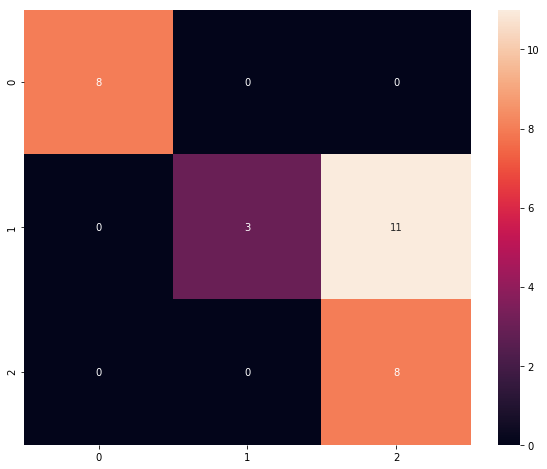

In [40]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');